In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_simple_network, set_seed

C:\Users\This MC\AppData\Local\Temp\ipykernel_13740\2757112305.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(1)

C:\Users\This MC\AppData\Local\Temp\ipykernel_13740\3171786389.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
import torchvision 
from torchvision import transforms

In [4]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True)
x_example, y_example = mnist_data_train[0]
type(x_example)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 16649771.39it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 781798.02it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 7340323.59it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4704995.99it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



PIL.Image.Image

In [5]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
x_example, y_example = mnist_data_train[0]
print(x_example.shape)

torch.Size([1, 28, 28])


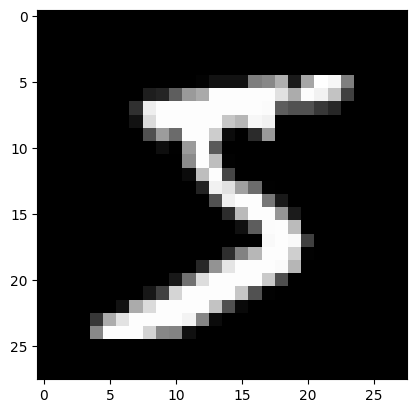

In [7]:
imshow(x_example[0,:], cmap='gray')

In [8]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]], dim=0)
print(x_as_color.shape)

torch.Size([3, 28, 28])


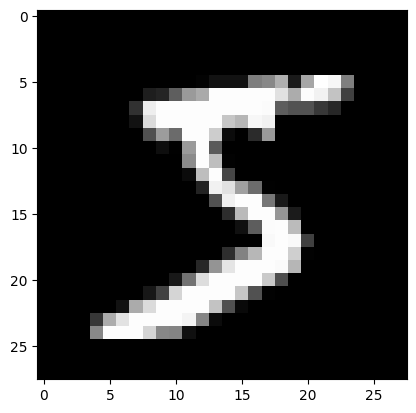

In [9]:
imshow(x_as_color.permute(1,2,0))

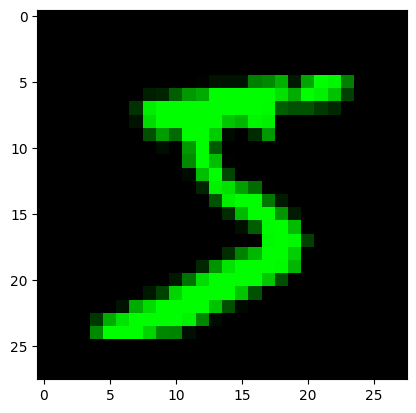

In [11]:
x_as_color = torch.stack([x_example[0,:], x_example[0,:], x_example[0,:]])
x_as_color[0,:] = 0 #No Red
#Leaving green alone
x_as_color[2,:] = 0 #No Blue
imshow(x_as_color.permute(1,2,0))

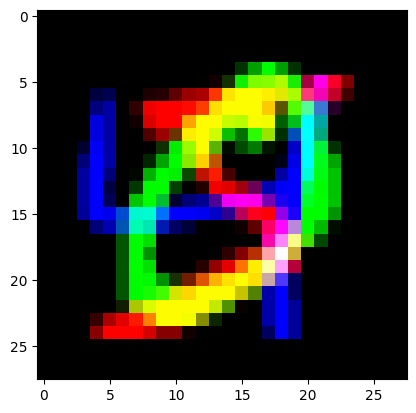

In [12]:
#grab 3 images
x1, x2, x3 = mnist_data_train[0], mnist_data_train[1], mnist_data_train[2]
#drop the labels
x1, x2, x3 = x1[0], x2[0], x3[0]
x_as_color = torch.stack([x1[0,:], x2[0,:], x3[0,:]], dim=0)
imshow(x_as_color.permute(1,2,0))

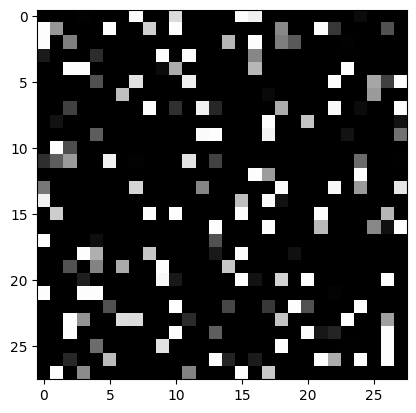

In [13]:
rand_order = torch.randperm(x_example.shape[1] * x_example.shape[2])
x_shuffled = x_example.view(-1)[rand_order].view(x_example.shape)
imshow(x_shuffled[0,:], cmap='gray')

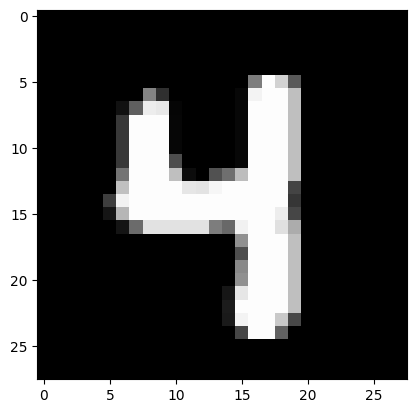

In [14]:
from scipy.signal import convolve
img_indx = 58
img = mnist_data_train[img_indx][0][0,:]
plt.imshow(img, vmin=0, vmax=1, cmap='gray')

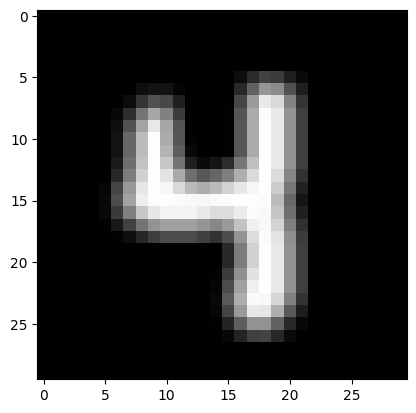

In [15]:
blur_filter = np.asarray([[1,1,1],
                          [1,1,1],
                          [1,1,1]
                         ])/9.0

blurry_img = convolve(img, blur_filter)
plt.imshow(blurry_img, vmin=0, vmax=1, cmap='gray')
plt.show()

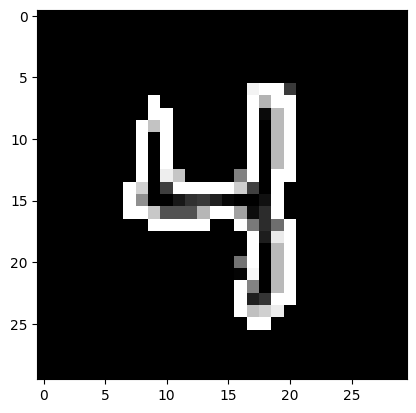

In [16]:
#We can find edges by focusing on the difference between a pixel, and its neighbors
edge_filter = np.asarray([[-1,-1,-1],
                          [-1, 8,-1],
                          [-1,-1,-1]
                         ])


edge_img = convolve(img, edge_filter)
plt.imshow(edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

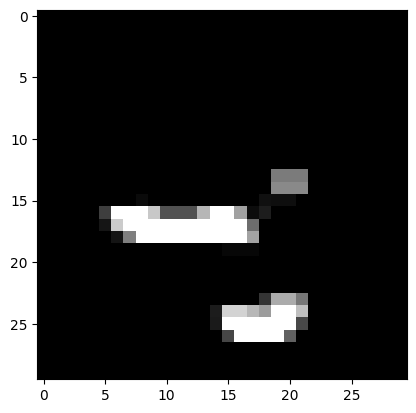

In [17]:
#We could look for only horizontal edges
h_edge_filter = np.asarray([[-1,-1,-1],
                          [0, 0,0],
                          [1, 1, 1]
                         ])


h_edge_img = convolve(img, h_edge_filter)
plt.imshow(h_edge_img, vmin=0, vmax=1, cmap='gray')
plt.show()

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

B = 32
mnist_train_loader = DataLoader(mnist_data_train, batch_size=B, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=B)

In [20]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10
#How many filters should we use
filters = 16
#how large should our filters be?
K = 3
#for comparison, lets define a linear model of similar complexity
model_linear = nn.Sequential(
  nn.Flatten(), #(B, C, W, H) -> (B, C*W*H) = (B,D)
  nn.Linear(D, 256), 
  nn.Tanh(),
  nn.Linear(256, classes),
)

#A simple convolutional network:
model_cnn = nn.Sequential(
  #Conv2d follows the pattern of:
  #Conv2d(# of input channels, #filters/output-channels, #filter-size)
  nn.Conv2d(C, filters, K, padding=K//2), #$x \circledast G$
  nn.Tanh(),#Activation functions work on any size tensor
  nn.Flatten(), #Convert from (B, C, W, H) ->(B, D). This way we can use a Linear layer after
  nn.Linear(filters*D, classes),
)

In [23]:
from torchsummary import summary

summary(model_linear, torch.zeros(1,1,28,28))
summary(model_cnn, torch.zeros(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Linear: 1-2                            [-1, 256]                 200,960
├─Tanh: 1-3                              [-1, 256]                 --
├─Linear: 1-4                            [-1, 10]                  2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.78
Estimated Total Size (MB): 0.78
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 28, 28]          160
├─Tanh: 1-2                              [-1, 16, 28, 28]          --
├─Flatten: 1-3                           [-1, 12544]               --
├─Linear: 1-4                            [-1, 10]                  125,450
Total params: 125,610
Trainable params: 125,610
Non-trainable p

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 28, 28]          160
├─Tanh: 1-2                              [-1, 16, 28, 28]          --
├─Flatten: 1-3                           [-1, 12544]               --
├─Linear: 1-4                            [-1, 10]                  125,450
Total params: 125,610
Trainable params: 125,610
Non-trainable params: 0
Total mult-adds (M): 0.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.48
Estimated Total Size (MB): 0.58

In [24]:
loss_func = nn.CrossEntropyLoss()
cnn_results = train_simple_network(model_cnn, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)
fc_results = train_simple_network(model_linear, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

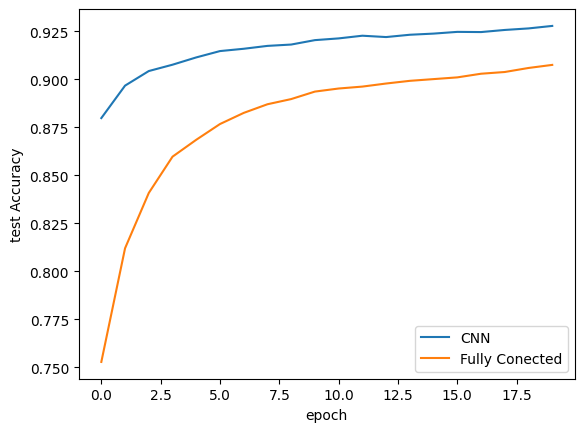

In [25]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=fc_results, label='Fully Conected')

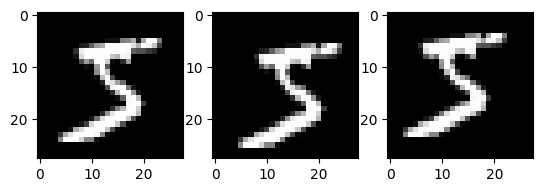

In [28]:
img_indx = 0
img, correct_class = mnist_data_train[img_indx]
img = img[0,:]
#move to the lower right, then upper left
img_lr = np.roll(np.roll(img, 1, axis=1), 1, axis=0)
img_ul = np.roll(np.roll(img, -1, axis=1), -1, axis=0)
#plot the images
f, axarr = plt.subplots(1,3)
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(img_lr, cmap='gray')
axarr[2].imshow(img_ul, cmap='gray')
plt.show()

In [29]:
#eval mode since we are not training
model = model_cnn.cpu().eval()

def pred(model, img):
    with torch.no_grad():#Always turn off gradients when evaluating
        w, h = img.shape#Whats the width/height of the image
        if not isinstance(img, torch.Tensor):
            img = torch.tensor(img)
        x = img.reshape(1,-1,w,h)#reshape it as (B, C, W, H)
        logits = model(x) #Get the logits
        y_hat = F.softmax(logits, dim=1)#Turn into probabilities 
        return y_hat.numpy().flatten()#convert prediction to numpy array. 

In [30]:
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class) , img_ul_pred[correct_class])

Org Img Class 5 Prob:          0.83023214
Lower Right Img Class 5 Prob:  0.5140542
Uper Left Img Class 5 Prob:    0.3703469


In [31]:
model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),

  nn.Flatten(), 
  #Why did we reduce the number of units into the Linear layer by a factor of $4^2$? Because pooling a 2x2 grid down to one value means we go from 4 values, down to 1, and we did this two times. 
  nn.Linear(2*filters*D//(4**2), classes),
)

cnn_results_with_pool = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader, test_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

In [32]:
model = model_cnn_pool.cpu().eval()
img_pred = pred(model, img)
img_lr_pred = pred(model, img_lr)
img_ul_pred = pred(model, img_ul)

print("Org Img Class {} Prob:         ".format(correct_class) , img_pred[correct_class])
print("Lower Right Img Class {} Prob: ".format(correct_class) , img_lr_pred[correct_class])
print("Uper Left Img Class {} Prob:   ".format(correct_class) , img_ul_pred[correct_class])

Org Img Class 5 Prob:          0.7575714
Lower Right Img Class 5 Prob:  0.7927357
Uper Left Img Class 5 Prob:    0.8065639


<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

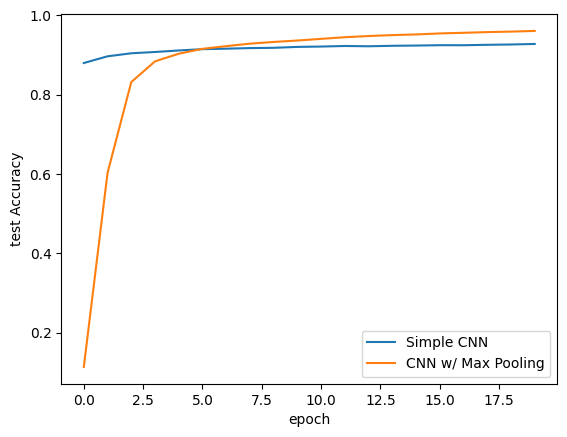

In [33]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results, label='Simple CNN')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')

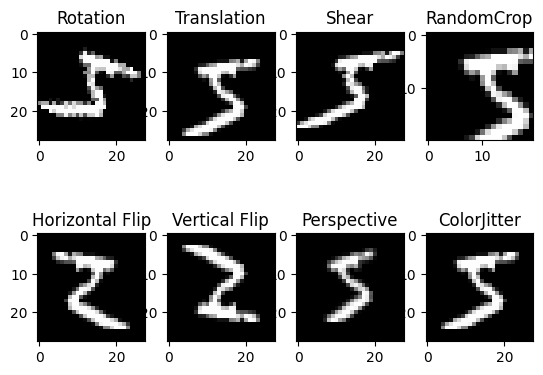

In [34]:
#Several built-in transformations, given some agressive values to make their impact more obvious.  
sample_transforms = {
    "Rotation" : transforms.RandomAffine(degrees=45),
    "Translation" : transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    "Shear": transforms.RandomAffine(degrees=0, shear=45),
    "RandomCrop" : transforms.RandomCrop((20,20)),
    "Horizontal Flip" : transforms.RandomHorizontalFlip(p=1.0),
    "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
    "Perspective": transforms.RandomPerspective(p=1.0),   
    "ColorJitter" : transforms.ColorJitter(brightness=0.9, contrast=0.9)
}
#Convert the Tensor image back to a PIL image using a transform
pil_img = transforms.ToPILImage()(img)
#Plot a randomy application of each transform
f, axarr = plt.subplots(2,4)
for count, (name, t) in enumerate(sample_transforms.items()):
    row = count % 4
    col = count // 4
    axarr[col,row].imshow(t(pil_img), cmap='gray')
    axarr[col,row].set_title(name)
plt.show()

In [35]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.98, 1.02)),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

mnist_train_t = torchvision.datasets.MNIST("./data", train=True, transform=train_transform)
mnist_test_t = torchvision.datasets.MNIST("./data", train=False, transform=test_transform)
mnist_train_loader_t = DataLoader(mnist_train_t, shuffle=True,  batch_size=B, num_workers=5)
mnist_test_loader_t = DataLoader(mnist_test_t, batch_size=B, num_workers=5)

In [36]:
model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(filters, filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Conv2d(filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.Conv2d(2*filters, 2*filters, 3, padding=3//2), 
  nn.Tanh(),
  nn.MaxPool2d(2),
  nn.Flatten(), 
  nn.Linear(2*filters*D//(4**2), classes),
)

cnn_results_with_pool_augmented = train_simple_network(model_cnn_pool, loss_func, mnist_train_loader_t, test_loader=mnist_test_loader_t, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

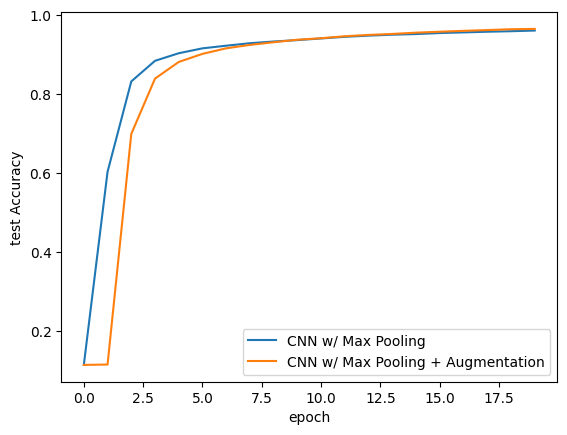

In [38]:
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool, label='CNN w/ Max Pooling')
sns.lineplot(x='epoch', y='test Accuracy', data=cnn_results_with_pool_augmented, label='CNN w/ Max Pooling + Augmentation')


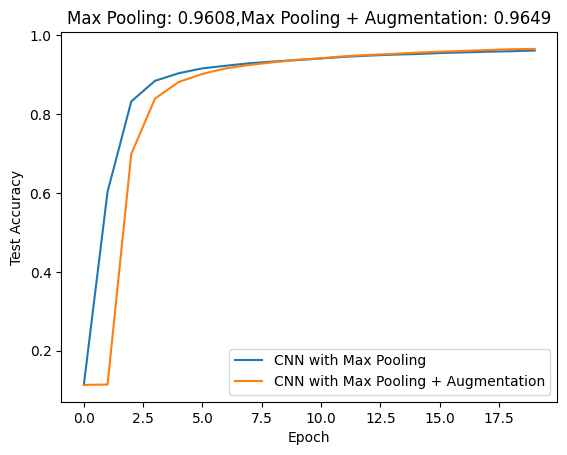

In [48]:
import matplotlib.pyplot as plt

# Assuming cnn_results_with_pool and cnn_results_with_pool_augmented are pandas DataFrames with column 'epoch' and 'test Accuracy'

epochs = cnn_results_with_pool['epoch']

# Test Accuracy for CNN with Max Pooling
accuracy_pool = cnn_results_with_pool['test Accuracy']

# Test Accuracy for CNN with Max Pooling + Augmentation
accuracy_pool_augmented = cnn_results_with_pool_augmented['test Accuracy']

# Plotting
plt.plot(epochs, accuracy_pool, label='CNN with Max Pooling')
plt.plot(epochs, accuracy_pool_augmented, label='CNN with Max Pooling + Augmentation')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title(f"Max Pooling: {accuracy_pool.iloc[-1]},Max Pooling + Augmentation: {accuracy_pool_augmented.iloc[-1]}" )


# Adding titles for each plot
#plt.text(epochs.iloc[-1], accuracy_pool.iloc[-1], f"Max Pooling: {accuracy_pool.iloc[-1]}", ha='right')
#plt.text(epochs.iloc[-1], accuracy_pool_augmented.iloc[-1], f"Max Pooling + Augmentation: {accuracy_pool_augmented.iloc[-1]}", ha='right')

plt.legend()

plt.show()
